# Импортируем необходимые библиотеки

In [3]:
import pandas as pd
import matplotlib.pylab as plt
from matplotlib import pyplot
%matplotlib inline
from matplotlib.pylab import rcParams
import xgboost as xgb
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

Wall time: 5.07 s


# Импортируем исходные данные
Для анализа мной был взять датасет с результатами игр в Dota2 за один день. Исходная ссылка: https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results

In [4]:
columnNames = ['IsWon', 'ClusterId', 'GameMode', 'GameType', 'AntiMage', 'Axe', 'Bane', 'Bloodseeker', 'CrystalMaiden', 'DrowRanger',
          'Earthshaker', 'Juggernaut','Mirana', 'Shadow Fiend', 'Morphling', 'PhantomLancer', 'Puck', 'Pudge', 'Razor','SandKing',
          'StormSpirit','Sven','Tiny','VengefulSpirit','Windranger','Zeus','Kunkka','Lina','Lich','Lion','ShadowShaman',
          'Slardar','Tidehunter','Witch Doctor','Riki','Enigma','Tinker','Sniper','Necrophos','Warlock','Beastmaster','QueenOfPain',
          'Venomancer','FacelessVoid','SkeletonKing','DeathProphet','PhantomAssassin','Pugna','TemplarAssassin','Viper','Luna',
          'DragonKnight','Dazzle','Clockwerk','Leshrac','NaturesProphet', 'Lifestealer','Dark Seer','Clinkz','Omniknight','Enchantress',
          'Huskar','NightStalker','Broodmother','BountyHunter','Weaver','Jakiro','Batrider','Chen','Spectre','Doom','AncientApparition',
          'Ursa','SpiritBreaker','Gyrocopter','Alchemist','Invoker','Silencer','OutworldDevourer','Lycanthrope','Brewmaster',
          'ShadowDemon','LoneDruid','ChaosKnight','Meepo','TreantProtector','OgreMagi','Undying','Rubick','Disruptor','NyxAssassin',
          'NagaSiren','KeeperOfTheLight','Wisp','Visage','Slark','Medusa','TrollWarlord','CentaurWarrunner','Magnus',
          'Timbersaw','Bristleback','Tusk','Skywrath Mage','Abaddon','ElderTitan', 'LegionCommander', 'Techies',
          'EmberSpirit','EarthSpirit','AbyssalUnderlord','Terrorblade','Phoenix','Oracle','WinterWyvern','ArcWarden','MonkeyKing']
train = pd.read_csv('dota2Train.csv', names = columnNames)
test = pd.read_csv('dota2Test.csv', names = columnNames)

Данный датасет был уже разбит на обучающую и тестовую выборки. Проверим их размерности и основные параметры:

In [5]:
train.shape

(92650, 117)

In [6]:
test.shape

(10294, 117)

In [31]:
train.describe()

,IsWon,ClusterId,GameMode,GameType,AntiMage,Axe,Bane,Bloodseeker,CrystalMaiden,DrowRanger,...,Techies,EmberSpirit,EarthSpirit,AbyssalUnderlord,Terrorblade,Phoenix,Oracle,WinterWyvern,ArcWarden,MonkeyKing
count,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000,...,92650.000000,92650.000000,92650.000000,92650.000000,92650.0,92650.000000,92650.000000,92650.000000,92650.000000,92650.000000
mean,0.053038,175.864145,3.317572,2.384587,-0.001630,-0.000971,0.000691,-0.000799,-0.002008,0.003173,...,-0.001371,-0.000950,0.000885,0.000594,0.0,0.001025,0.000648,-0.000227,-0.000043,0.000896
std,0.998598,35.658214,2.633070,0.486833,0.402004,0.467672,0.165052,0.355393,0.329348,0.483950,...,0.535024,0.206112,0.283985,0.155940,0.0,0.220703,0.204166,0.168707,0.189868,0.139033
min,-1.000000,111.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,152.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,156.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,223.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,261.000000,9.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
test.head()

,IsWon,ClusterId,GameMode,GameType,AntiMage,Axe,Bane,Bloodseeker,CrystalMaiden,DrowRanger,...,Techies,EmberSpirit,EarthSpirit,AbyssalUnderlord,Terrorblade,Phoenix,Oracle,WinterWyvern,ArcWarden,MonkeyKing
0,-1,223,8,2,0,-1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
1,1,227,8,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
2,-1,136,2,2,1,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,227,2,2,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,184,2,3,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


В данных выборках находится в сумме 102944 записей и 117 атрибутов, где каждая запись - это отдельно взятая игра, где:

 1) IsWon - выиграна данная игра или нет

 2) ClusterId - Id региона, где данная игра проходила (Восточная, Западная Европа, Северная, Южная Америка и т.п)

 3) GameMode - Режим игры (All pick - свободный выбор героя, Random Draft - выбор из рандомного пула героев и т.д.)

4) Тип игры - Тип игры (Рейтинговая, обычная и т.д.)

 5 - 117) Данные по всем героям, в каждом ряду(игре) находится информация о 10 героях, которые были в данное игре, и в какой команде были выбраны (1 - победителей, -1 - проигравших)

Исходя из размерностей обучающей и тестовой выборок, можно сделать вывод, что они поделены в соотношении 10% и 90%. В таком соотношении обучающая выборка является слишком большой и скорее всего результат на тестовой выборке будет не совсем удовлетворительным. 
### Поэтому объединим данные выборки в один датасет:

In [43]:
all_data = pd.concat((train, test), sort=True).reset_index(drop=True)
data = pd.get_dummies(all_data, columns=['GameMode', 'GameType', 'ClusterId'])

In [44]:
all_data.shape

(102944, 117)

## Выделим целевую переменную.

In [13]:
y = all_data.pop('IsWon')
X = all_data

## Разобьем данные на обучающую и тестовую выборки в новом соотношении

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Создадим наш классификатор и обучим при стандартных параметрах

In [15]:
%%time
eval_set = [(X_train, y_train), (X_test, y_test)]
clf = XGBClassifier()
clf.fit(X_train, y_train, eval_metric=["logloss", "auc"],  early_stopping_rounds=10, eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.692078	validation_0-auc:0.542131	validation_1-logloss:0.692211	validation_1-auc:0.534229
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.691186	validation_0-auc:0.546906	validation_1-logloss:0.691408	validation_1-auc:0.538444
[2]	validation_0-logloss:0.690447	validation_0-auc:0.551158	validation_1-logloss:0.690746	validation_1-auc:0.542666
[3]	validation_0-logloss:0.689824	validation_0-auc:0.555241	validation_1-logloss:0.690197	validation_1-auc:0.547377
[4]	validation_0-logloss:0.689223	validation_0-auc:0.565329	validation_1-logloss:0.689655	validation_1-auc:0.555923
[5]	validation_0-logloss:0.688698	validation_0-auc:0.568289	validation_1-logloss:0.689191	validation_1-auc:0.557958
[6]	validation_0-logloss:0.6882	validation_0-auc:0.571582	validation_1-logloss:0.688818	validation_1-auc:0.560971
[7]	validation_0-logloss:0.687747

[69]	validation_0-logloss:0.674021	validation_0-auc:0.62742	validation_1-logloss:0.678088	validation_1-auc:0.604929
[70]	validation_0-logloss:0.673874	validation_0-auc:0.628038	validation_1-logloss:0.678026	validation_1-auc:0.605159
[71]	validation_0-logloss:0.673717	validation_0-auc:0.628444	validation_1-logloss:0.677909	validation_1-auc:0.605486
[72]	validation_0-logloss:0.673575	validation_0-auc:0.628644	validation_1-logloss:0.677833	validation_1-auc:0.605575
[73]	validation_0-logloss:0.673425	validation_0-auc:0.62892	validation_1-logloss:0.677732	validation_1-auc:0.605747
[74]	validation_0-logloss:0.673288	validation_0-auc:0.629473	validation_1-logloss:0.6776	validation_1-auc:0.606474
[75]	validation_0-logloss:0.673151	validation_0-auc:0.629699	validation_1-logloss:0.677516	validation_1-auc:0.606595
[76]	validation_0-logloss:0.673016	validation_0-auc:0.629793	validation_1-logloss:0.677411	validation_1-auc:0.606788
[77]	validation_0-logloss:0.672878	validation_0-auc:0.630183	validat

In [16]:
y_predictions = clf.predict(X_test)
y_pred = clf.predict_proba(X_test)[:,1]

C:\Users\zherdev.p\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Итоговые метрики классификатора

In [47]:
print("Score:")
print(clf.score(X_test, y_test))
print("LogLoss: ")
print(log_loss(y_test, y_pred))
print ("AUC Score : ")
print(roc_auc_score(y_test, y_pred))

Score:
0.583274461321088
LogLoss: 
0.6655186211334357
AUC Score : 
0.6282905561812105


C:\Users\zherdev.p\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Визуализируем данные

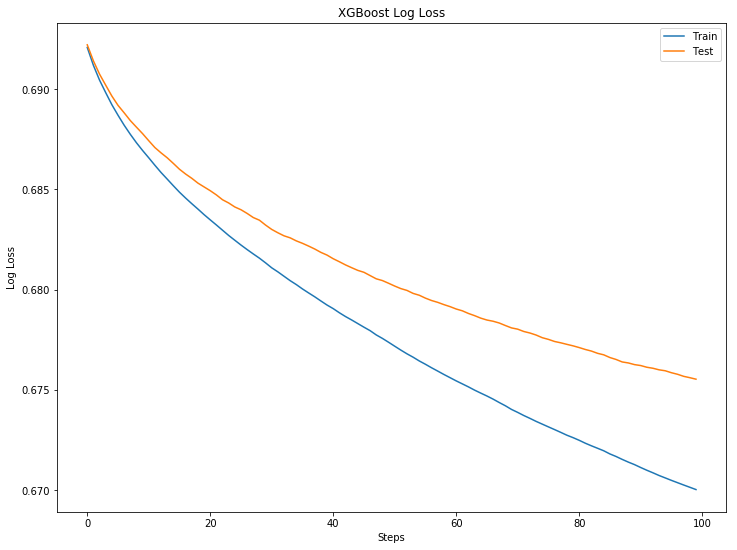

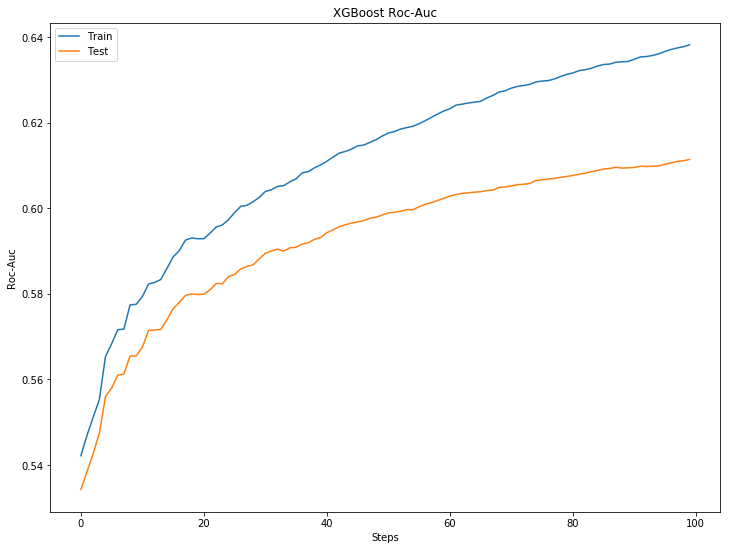

In [18]:
results = clf.evals_result()
steps = len(results['validation_0']['auc'])
x_axis = range(0, steps)

fig, ax = pyplot.subplots(figsize=(12, 9))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.xlabel('Steps')
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

fig, ax = pyplot.subplots(figsize=(12, 9))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.xlabel('Steps')
pyplot.ylabel('Roc-Auc')
pyplot.title('XGBoost Roc-Auc')
pyplot.show()

Можно сделать вывод, что данная модель будет давать нам точность прогноза лишь в 58% случаев

## Для того чтобы увеличить состоятельность модели произведем подбор гиперпараметров для обучения XGBoost-классификатора, с помощью GridSearchCV

In [19]:
%%time
eval_set = [(X_train, y_train), (X_test, y_test)]
model = XGBClassifier()
param_test = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'n_estimators':[100, 200, 300, 400, 500]
}
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_test, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train, eval_metric=["logloss", "auc"],  early_stopping_rounds=50, eval_set=eval_set, verbose=True)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 54.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 151.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 265.9min finished


[0]	validation_0-logloss:0.692078	validation_0-auc:0.542131	validation_1-logloss:0.692211	validation_1-auc:0.534229
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.691186	validation_0-auc:0.546906	validation_1-logloss:0.691408	validation_1-auc:0.538444
[2]	validation_0-logloss:0.690447	validation_0-auc:0.551158	validation_1-logloss:0.690746	validation_1-auc:0.542666
[3]	validation_0-logloss:0.689824	validation_0-auc:0.555241	validation_1-logloss:0.690197	validation_1-auc:0.547377
[4]	validation_0-logloss:0.689223	validation_0-auc:0.565329	validation_1-logloss:0.689655	validation_1-auc:0.555923
[5]	validation_0-logloss:0.688698	validation_0-auc:0.568289	validation_1-logloss:0.689191	validation_1-auc:0.557958
[6]	validation_0-logloss:0.6882	validation_0-auc:0.571582	validation_1-logloss:0.688818	validation_1-auc:0.560971
[7]	validation_0-logloss:0.687747

[69]	validation_0-logloss:0.674021	validation_0-auc:0.62742	validation_1-logloss:0.678088	validation_1-auc:0.604929
[70]	validation_0-logloss:0.673874	validation_0-auc:0.628038	validation_1-logloss:0.678026	validation_1-auc:0.605159
[71]	validation_0-logloss:0.673717	validation_0-auc:0.628444	validation_1-logloss:0.677909	validation_1-auc:0.605486
[72]	validation_0-logloss:0.673575	validation_0-auc:0.628644	validation_1-logloss:0.677833	validation_1-auc:0.605575
[73]	validation_0-logloss:0.673425	validation_0-auc:0.62892	validation_1-logloss:0.677732	validation_1-auc:0.605747
[74]	validation_0-logloss:0.673288	validation_0-auc:0.629473	validation_1-logloss:0.6776	validation_1-auc:0.606474
[75]	validation_0-logloss:0.673151	validation_0-auc:0.629699	validation_1-logloss:0.677516	validation_1-auc:0.606595
[76]	validation_0-logloss:0.673016	validation_0-auc:0.629793	validation_1-logloss:0.677411	validation_1-auc:0.606788
[77]	validation_0-logloss:0.672878	validation_0-auc:0.630183	validat

[140]	validation_0-logloss:0.665568	validation_0-auc:0.647951	validation_1-logloss:0.672887	validation_1-auc:0.617081
[141]	validation_0-logloss:0.665461	validation_0-auc:0.648281	validation_1-logloss:0.672836	validation_1-auc:0.617152
[142]	validation_0-logloss:0.665342	validation_0-auc:0.648692	validation_1-logloss:0.672777	validation_1-auc:0.617319
[143]	validation_0-logloss:0.665255	validation_0-auc:0.648939	validation_1-logloss:0.672702	validation_1-auc:0.617623
[144]	validation_0-logloss:0.665165	validation_0-auc:0.649282	validation_1-logloss:0.672665	validation_1-auc:0.617751
[145]	validation_0-logloss:0.665069	validation_0-auc:0.649362	validation_1-logloss:0.672625	validation_1-auc:0.617712
[146]	validation_0-logloss:0.66497	validation_0-auc:0.649694	validation_1-logloss:0.672566	validation_1-auc:0.617932
[147]	validation_0-logloss:0.664866	validation_0-auc:0.649912	validation_1-logloss:0.672492	validation_1-auc:0.6181
[148]	validation_0-logloss:0.664777	validation_0-auc:0.6499

[210]	validation_0-logloss:0.659624	validation_0-auc:0.659869	validation_1-logloss:0.669835	validation_1-auc:0.622356
[211]	validation_0-logloss:0.65956	validation_0-auc:0.659915	validation_1-logloss:0.669785	validation_1-auc:0.622471
[212]	validation_0-logloss:0.659492	validation_0-auc:0.66007	validation_1-logloss:0.669773	validation_1-auc:0.622438
[213]	validation_0-logloss:0.659411	validation_0-auc:0.660174	validation_1-logloss:0.669723	validation_1-auc:0.622481
[214]	validation_0-logloss:0.659325	validation_0-auc:0.660415	validation_1-logloss:0.669691	validation_1-auc:0.622569
[215]	validation_0-logloss:0.659258	validation_0-auc:0.660443	validation_1-logloss:0.669651	validation_1-auc:0.622611
[216]	validation_0-logloss:0.659197	validation_0-auc:0.660469	validation_1-logloss:0.669636	validation_1-auc:0.622588
[217]	validation_0-logloss:0.659118	validation_0-auc:0.660675	validation_1-logloss:0.66962	validation_1-auc:0.622636
[218]	validation_0-logloss:0.659043	validation_0-auc:0.6608

[280]	validation_0-logloss:0.654937	validation_0-auc:0.667857	validation_1-logloss:0.668058	validation_1-auc:0.624762
[281]	validation_0-logloss:0.654878	validation_0-auc:0.667932	validation_1-logloss:0.668022	validation_1-auc:0.624839
[282]	validation_0-logloss:0.654826	validation_0-auc:0.668048	validation_1-logloss:0.667996	validation_1-auc:0.624892
[283]	validation_0-logloss:0.654777	validation_0-auc:0.668093	validation_1-logloss:0.667977	validation_1-auc:0.624904
[284]	validation_0-logloss:0.654715	validation_0-auc:0.668195	validation_1-logloss:0.667977	validation_1-auc:0.624871
[285]	validation_0-logloss:0.654666	validation_0-auc:0.668273	validation_1-logloss:0.667937	validation_1-auc:0.624969
[286]	validation_0-logloss:0.654614	validation_0-auc:0.668303	validation_1-logloss:0.667908	validation_1-auc:0.62499
[287]	validation_0-logloss:0.654551	validation_0-auc:0.668453	validation_1-logloss:0.667903	validation_1-auc:0.624977
[288]	validation_0-logloss:0.654485	validation_0-auc:0.66

[350]	validation_0-logloss:0.651144	validation_0-auc:0.673929	validation_1-logloss:0.666786	validation_1-auc:0.626679
[351]	validation_0-logloss:0.651095	validation_0-auc:0.67399	validation_1-logloss:0.666773	validation_1-auc:0.626711
[352]	validation_0-logloss:0.651054	validation_0-auc:0.674	validation_1-logloss:0.666743	validation_1-auc:0.626759
[353]	validation_0-logloss:0.650996	validation_0-auc:0.674154	validation_1-logloss:0.666738	validation_1-auc:0.626779
[354]	validation_0-logloss:0.650945	validation_0-auc:0.674249	validation_1-logloss:0.666728	validation_1-auc:0.626808
[355]	validation_0-logloss:0.650892	validation_0-auc:0.674287	validation_1-logloss:0.666724	validation_1-auc:0.626823
[356]	validation_0-logloss:0.650833	validation_0-auc:0.674435	validation_1-logloss:0.666713	validation_1-auc:0.626857
[357]	validation_0-logloss:0.650787	validation_0-auc:0.674518	validation_1-logloss:0.666712	validation_1-auc:0.626823
[358]	validation_0-logloss:0.650727	validation_0-auc:0.67457

[420]	validation_0-logloss:0.647817	validation_0-auc:0.679025	validation_1-logloss:0.666006	validation_1-auc:0.627667
[421]	validation_0-logloss:0.647765	validation_0-auc:0.679092	validation_1-logloss:0.665987	validation_1-auc:0.627711
[422]	validation_0-logloss:0.647718	validation_0-auc:0.67917	validation_1-logloss:0.665983	validation_1-auc:0.627697
[423]	validation_0-logloss:0.647676	validation_0-auc:0.679244	validation_1-logloss:0.665984	validation_1-auc:0.627677
[424]	validation_0-logloss:0.647629	validation_0-auc:0.679355	validation_1-logloss:0.665982	validation_1-auc:0.627682
[425]	validation_0-logloss:0.647586	validation_0-auc:0.679434	validation_1-logloss:0.66597	validation_1-auc:0.627708
[426]	validation_0-logloss:0.647534	validation_0-auc:0.679538	validation_1-logloss:0.665976	validation_1-auc:0.62768
[427]	validation_0-logloss:0.647485	validation_0-auc:0.679648	validation_1-logloss:0.665984	validation_1-auc:0.627652
[428]	validation_0-logloss:0.647435	validation_0-auc:0.6796

[490]	validation_0-logloss:0.644929	validation_0-auc:0.683618	validation_1-logloss:0.665583	validation_1-auc:0.628238
[491]	validation_0-logloss:0.644895	validation_0-auc:0.683674	validation_1-logloss:0.665592	validation_1-auc:0.628194
[492]	validation_0-logloss:0.64486	validation_0-auc:0.683719	validation_1-logloss:0.665574	validation_1-auc:0.628224
[493]	validation_0-logloss:0.644828	validation_0-auc:0.683765	validation_1-logloss:0.665565	validation_1-auc:0.628242
[494]	validation_0-logloss:0.644801	validation_0-auc:0.683766	validation_1-logloss:0.665557	validation_1-auc:0.62825
[495]	validation_0-logloss:0.644768	validation_0-auc:0.683817	validation_1-logloss:0.665539	validation_1-auc:0.628277
[496]	validation_0-logloss:0.644741	validation_0-auc:0.683845	validation_1-logloss:0.665539	validation_1-auc:0.628274
[497]	validation_0-logloss:0.644701	validation_0-auc:0.683902	validation_1-logloss:0.665522	validation_1-auc:0.628312
[498]	validation_0-logloss:0.644662	validation_0-auc:0.683

Исходя из полученных данных, получаем что лучший набор из трех выбранных параметров является таковым max_depth = 3, min_child_weight = 1, n_estimators = 500. 

Можно было сделать подбор и большего числа параметров, но исходя результата подбора только 3х можно сделать вывод, что эта операция довольно таки ресурсоемкая, так как она заняла 4.5 часа "пыхтения" на полной мощности бедного Intel Core I5-7500

## Произведем обучение классификатора при полученных параметрах

In [38]:
%%time
eval_set = [(X_train, y_train), (X_test, y_test)]
clf1 = XGBClassifier(max_depth = 3, min_child_weight = 1, n_estimators = 500)
clf1.fit(X_train, y_train, eval_metric=["logloss", "auc"], eval_set=eval_set)

[0]	validation_0-logloss:0.692078	validation_0-auc:0.542131	validation_1-logloss:0.692211	validation_1-auc:0.534229
[1]	validation_0-logloss:0.691186	validation_0-auc:0.546906	validation_1-logloss:0.691408	validation_1-auc:0.538444
[2]	validation_0-logloss:0.690447	validation_0-auc:0.551158	validation_1-logloss:0.690746	validation_1-auc:0.542666
[3]	validation_0-logloss:0.689824	validation_0-auc:0.555241	validation_1-logloss:0.690197	validation_1-auc:0.547377
[4]	validation_0-logloss:0.689223	validation_0-auc:0.565329	validation_1-logloss:0.689655	validation_1-auc:0.555923
[5]	validation_0-logloss:0.688698	validation_0-auc:0.568289	validation_1-logloss:0.689191	validation_1-auc:0.557958
[6]	validation_0-logloss:0.6882	validation_0-auc:0.571582	validation_1-logloss:0.688818	validation_1-auc:0.560971
[7]	validation_0-logloss:0.687747	validation_0-auc:0.57174	validation_1-logloss:0.688432	validation_1-auc:0.561251
[8]	validation_0-logloss:0.687324	validation_0-auc:0.577388	validation_1-lo

[71]	validation_0-logloss:0.673717	validation_0-auc:0.628444	validation_1-logloss:0.677909	validation_1-auc:0.605486
[72]	validation_0-logloss:0.673575	validation_0-auc:0.628644	validation_1-logloss:0.677833	validation_1-auc:0.605575
[73]	validation_0-logloss:0.673425	validation_0-auc:0.62892	validation_1-logloss:0.677732	validation_1-auc:0.605747
[74]	validation_0-logloss:0.673288	validation_0-auc:0.629473	validation_1-logloss:0.6776	validation_1-auc:0.606474
[75]	validation_0-logloss:0.673151	validation_0-auc:0.629699	validation_1-logloss:0.677516	validation_1-auc:0.606595
[76]	validation_0-logloss:0.673016	validation_0-auc:0.629793	validation_1-logloss:0.677411	validation_1-auc:0.606788
[77]	validation_0-logloss:0.672878	validation_0-auc:0.630183	validation_1-logloss:0.677345	validation_1-auc:0.606937
[78]	validation_0-logloss:0.672736	validation_0-auc:0.630751	validation_1-logloss:0.677268	validation_1-auc:0.607193
[79]	validation_0-logloss:0.672615	validation_0-auc:0.631234	valida

[141]	validation_0-logloss:0.665461	validation_0-auc:0.648281	validation_1-logloss:0.672836	validation_1-auc:0.617152
[142]	validation_0-logloss:0.665342	validation_0-auc:0.648692	validation_1-logloss:0.672777	validation_1-auc:0.617319
[143]	validation_0-logloss:0.665255	validation_0-auc:0.648939	validation_1-logloss:0.672702	validation_1-auc:0.617623
[144]	validation_0-logloss:0.665165	validation_0-auc:0.649282	validation_1-logloss:0.672665	validation_1-auc:0.617751
[145]	validation_0-logloss:0.665069	validation_0-auc:0.649362	validation_1-logloss:0.672625	validation_1-auc:0.617712
[146]	validation_0-logloss:0.66497	validation_0-auc:0.649694	validation_1-logloss:0.672566	validation_1-auc:0.617932
[147]	validation_0-logloss:0.664866	validation_0-auc:0.649912	validation_1-logloss:0.672492	validation_1-auc:0.6181
[148]	validation_0-logloss:0.664777	validation_0-auc:0.649995	validation_1-logloss:0.672413	validation_1-auc:0.618211
[149]	validation_0-logloss:0.664685	validation_0-auc:0.6502

[211]	validation_0-logloss:0.65956	validation_0-auc:0.659915	validation_1-logloss:0.669785	validation_1-auc:0.622471
[212]	validation_0-logloss:0.659492	validation_0-auc:0.66007	validation_1-logloss:0.669773	validation_1-auc:0.622438
[213]	validation_0-logloss:0.659411	validation_0-auc:0.660174	validation_1-logloss:0.669723	validation_1-auc:0.622481
[214]	validation_0-logloss:0.659325	validation_0-auc:0.660415	validation_1-logloss:0.669691	validation_1-auc:0.622569
[215]	validation_0-logloss:0.659258	validation_0-auc:0.660443	validation_1-logloss:0.669651	validation_1-auc:0.622611
[216]	validation_0-logloss:0.659197	validation_0-auc:0.660469	validation_1-logloss:0.669636	validation_1-auc:0.622588
[217]	validation_0-logloss:0.659118	validation_0-auc:0.660675	validation_1-logloss:0.66962	validation_1-auc:0.622636
[218]	validation_0-logloss:0.659043	validation_0-auc:0.660814	validation_1-logloss:0.66957	validation_1-auc:0.622764
[219]	validation_0-logloss:0.658967	validation_0-auc:0.66108

[281]	validation_0-logloss:0.654878	validation_0-auc:0.667932	validation_1-logloss:0.668022	validation_1-auc:0.624839
[282]	validation_0-logloss:0.654826	validation_0-auc:0.668048	validation_1-logloss:0.667996	validation_1-auc:0.624892
[283]	validation_0-logloss:0.654777	validation_0-auc:0.668093	validation_1-logloss:0.667977	validation_1-auc:0.624904
[284]	validation_0-logloss:0.654715	validation_0-auc:0.668195	validation_1-logloss:0.667977	validation_1-auc:0.624871
[285]	validation_0-logloss:0.654666	validation_0-auc:0.668273	validation_1-logloss:0.667937	validation_1-auc:0.624969
[286]	validation_0-logloss:0.654614	validation_0-auc:0.668303	validation_1-logloss:0.667908	validation_1-auc:0.62499
[287]	validation_0-logloss:0.654551	validation_0-auc:0.668453	validation_1-logloss:0.667903	validation_1-auc:0.624977
[288]	validation_0-logloss:0.654485	validation_0-auc:0.668568	validation_1-logloss:0.667882	validation_1-auc:0.62499
[289]	validation_0-logloss:0.654425	validation_0-auc:0.668

[351]	validation_0-logloss:0.651095	validation_0-auc:0.67399	validation_1-logloss:0.666773	validation_1-auc:0.626711
[352]	validation_0-logloss:0.651054	validation_0-auc:0.674	validation_1-logloss:0.666743	validation_1-auc:0.626759
[353]	validation_0-logloss:0.650996	validation_0-auc:0.674154	validation_1-logloss:0.666738	validation_1-auc:0.626779
[354]	validation_0-logloss:0.650945	validation_0-auc:0.674249	validation_1-logloss:0.666728	validation_1-auc:0.626808
[355]	validation_0-logloss:0.650892	validation_0-auc:0.674287	validation_1-logloss:0.666724	validation_1-auc:0.626823
[356]	validation_0-logloss:0.650833	validation_0-auc:0.674435	validation_1-logloss:0.666713	validation_1-auc:0.626857
[357]	validation_0-logloss:0.650787	validation_0-auc:0.674518	validation_1-logloss:0.666712	validation_1-auc:0.626823
[358]	validation_0-logloss:0.650727	validation_0-auc:0.674579	validation_1-logloss:0.6667	validation_1-auc:0.626813
[359]	validation_0-logloss:0.650673	validation_0-auc:0.674687	

[421]	validation_0-logloss:0.647765	validation_0-auc:0.679092	validation_1-logloss:0.665987	validation_1-auc:0.627711
[422]	validation_0-logloss:0.647718	validation_0-auc:0.67917	validation_1-logloss:0.665983	validation_1-auc:0.627697
[423]	validation_0-logloss:0.647676	validation_0-auc:0.679244	validation_1-logloss:0.665984	validation_1-auc:0.627677
[424]	validation_0-logloss:0.647629	validation_0-auc:0.679355	validation_1-logloss:0.665982	validation_1-auc:0.627682
[425]	validation_0-logloss:0.647586	validation_0-auc:0.679434	validation_1-logloss:0.66597	validation_1-auc:0.627708
[426]	validation_0-logloss:0.647534	validation_0-auc:0.679538	validation_1-logloss:0.665976	validation_1-auc:0.62768
[427]	validation_0-logloss:0.647485	validation_0-auc:0.679648	validation_1-logloss:0.665984	validation_1-auc:0.627652
[428]	validation_0-logloss:0.647435	validation_0-auc:0.679689	validation_1-logloss:0.665985	validation_1-auc:0.62763
[429]	validation_0-logloss:0.647394	validation_0-auc:0.67974

[491]	validation_0-logloss:0.644895	validation_0-auc:0.683674	validation_1-logloss:0.665592	validation_1-auc:0.628194
[492]	validation_0-logloss:0.64486	validation_0-auc:0.683719	validation_1-logloss:0.665574	validation_1-auc:0.628224
[493]	validation_0-logloss:0.644828	validation_0-auc:0.683765	validation_1-logloss:0.665565	validation_1-auc:0.628242
[494]	validation_0-logloss:0.644801	validation_0-auc:0.683766	validation_1-logloss:0.665557	validation_1-auc:0.62825
[495]	validation_0-logloss:0.644768	validation_0-auc:0.683817	validation_1-logloss:0.665539	validation_1-auc:0.628277
[496]	validation_0-logloss:0.644741	validation_0-auc:0.683845	validation_1-logloss:0.665539	validation_1-auc:0.628274
[497]	validation_0-logloss:0.644701	validation_0-auc:0.683902	validation_1-logloss:0.665522	validation_1-auc:0.628312
[498]	validation_0-logloss:0.644662	validation_0-auc:0.683956	validation_1-logloss:0.665511	validation_1-auc:0.62832
[499]	validation_0-logloss:0.644615	validation_0-auc:0.6840

In [39]:
y_predictions = clf1.predict(X_test)
y_pred = clf1.predict_proba(X_test)[:,1]

C:\Users\zherdev.p\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [49]:
print("Score:")
print(clf1.score(X_test, y_test))
print("LogLoss: ")
print(log_loss(y_test, y_pred))
print ("AUC Score : ")
print(roc_auc_score(y_test, y_pred))

Score:
0.5939302955375014
LogLoss: 
0.6655186211334357
AUC Score : 
0.6282905561812105


C:\Users\zherdev.p\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


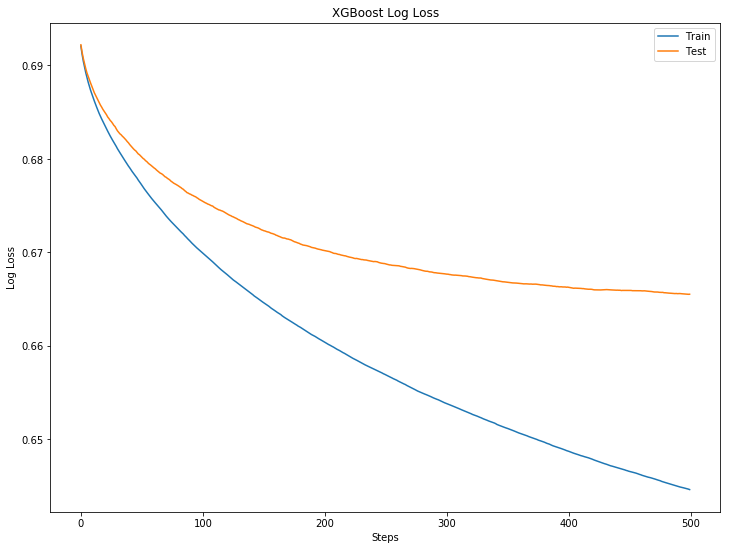

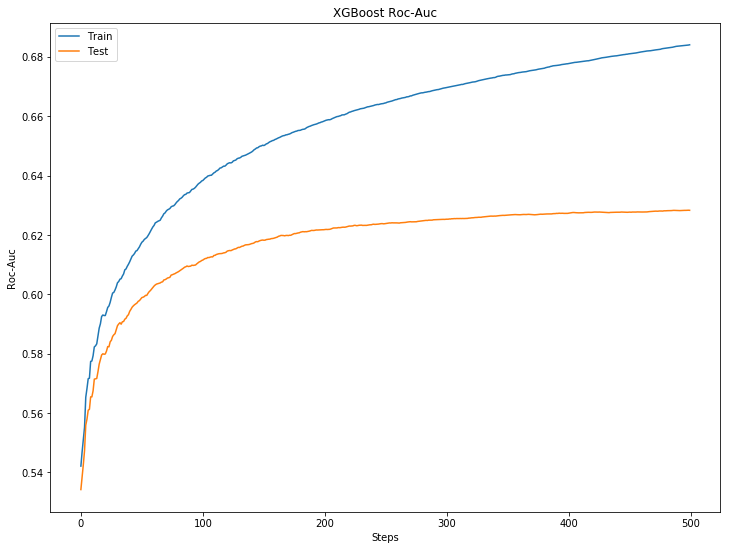

In [41]:
results = clf1.evals_result()
steps = len(results['validation_0']['auc'])
x_axis = range(0, steps)

fig, ax = pyplot.subplots(figsize=(12, 9))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.xlabel('Steps')
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

fig, ax = pyplot.subplots(figsize=(12, 9))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.xlabel('Steps')
pyplot.ylabel('Roc-Auc')
pyplot.title('XGBoost Roc-Auc')
pyplot.show()

Результат, конечно, нельзя назвать удовлетворительным и мы видим, что с каждым шагом метрики обучающей выборки отдаляются от тестовой. И вероятность верного прогноза выросла едва чуть больше чем на 1%.

# Вывод

Исходя из полученных результатов можно прийти к выводу, что модель получилось не совсем состоятельной. Скорее всего следует провести некоторый Feature engineering над данными, либо усложнить алгоритмы, либо получить увеличить количество данных, добавив допустим средний рейтинг игроков и так далее.